In [97]:
import pandas as pd 
import numpy as np 
import datetime as dt
from datetime import timedelta
import os
import sys
import pyodbc
import time
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

In [544]:
def datetime_range(start, end, delta):
    current = start
    if not isinstance(delta, timedelta):
        delta = timedelta(**delta)
    while current < end:
        yield current
        current += delta

# Bring in Punch In Data from HR 

In [716]:
punchTimesDF = pd.read_csv(r'/Users/sanjaygopinath/Documents/Data/foot_traffic_project/RetailDailyPunches.csv', index_col=None)

punchTimesDF.rename(columns= {'In Punch Date':'In_Date', 'In Punch Time':'In_Time', 'Out Punch Date':'Out_Date',
                                  'Out Punch Time':'Out_Time','Store Number':'Store_Number', 'EE Number':'EE_Number'}, inplace=True)
title_dictionary = {'Key Holder full time':'Key Holder', 'Key Holder Part Time':'Key Holder', 'Key Holder Part time':'Key Holder',
            'Key Holder part time':'Key Holder', 'Key Holder Full Time':'Key Holder', 'Sr. Sales Associate':'Sales Associate'}

punchTimesDF.replace({"Title": title_dictionary}, inplace=True)


#Combining date and hours into a single colummn 
punchTimesDF['in'] = punchTimesDF['In_Date'] + ' ' + punchTimesDF['In_Time']

punchTimesDF['out'] = punchTimesDF['Out_Date'] + ' ' + punchTimesDF['Out_Time']

#Converting to datetime 

punchTimesDF['in'] = pd.to_datetime(punchTimesDF['in'])
punchTimesDF['out'] = pd.to_datetime(punchTimesDF['out'])


#calculating the hours worked from our raw times 
punchTimesDF['raw_hours'] = punchTimesDF['out'] - punchTimesDF['in']

#ROunding the in and out dates to the nearest half hour 




punchTimesDF['rounded_in'] = punchTimesDF['in'].dt.round('15min')

punchTimesDF['rounded_out'] = punchTimesDF['out'].dt.round('15min')





#calcuatling the hours worked from our rounded times

punchTimesDF['rounded_hours'] = punchTimesDF['rounded_out'] - punchTimesDF['rounded_in']



In [537]:
[str(i) for i in list(punchTimesDF['Store_Number'].unique())]

['1',
 '2',
 '3',
 '6',
 '7',
 '9',
 '11',
 '12',
 '14',
 '15',
 '18',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '44',
 '46',
 '47',
 '48',
 '49',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '62',
 '63',
 '64',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '73',
 '75',
 '76',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '101',
 '105',
 '109',
 '114',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151',
 '152',
 '153',
 '155',
 '156',
 '157',
 '158',
 '159',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '175',
 '176',
 '177',
 '178',
 '179'

In [717]:
punchTimesDF.shape

(140859, 14)

In [718]:
#This bit creates a very narrow, long dataframe that should have every store number, every hour and every EE number
# that is in the punch data, we then use a groupby to get the number of unique names for each store hour, so that we know 
#the number of employees in the store at anyone time 


emptyFrame = pd.DataFrame()

for i in punchTimesDF.index:
    x = ([datetime_range(punchTimesDF['rounded_in'][i], punchTimesDF['rounded_out'][i], {'minutes':15})])
    tFrame= pd.DataFrame(x)
    tFrame = tFrame.transpose()
    tFrame.rename(columns={0:'hours'}, inplace=True)
    tFrame['EE_Number'] = punchTimesDF['EE_Number'][i]
    tFrame['Store_Number'] = punchTimesDF['Store_Number'][i]
    emptyFrame = emptyFrame.append(tFrame, )
    
grouped_emp_frame = emptyFrame['EE_Number'].groupby([emptyFrame['hours'], emptyFrame['Store_Number']]).nunique()
grouped_emp_frame = grouped_emp_frame.reset_index()
grouped_emp_frame.rename(columns={'EE_Number':'In_Store'}, inplace=True)

grouped_emp_frame = emptyFrame['EE_Number'].groupby([emptyFrame['hours'], emptyFrame['Store_Number']]).nunique()
grouped_emp_frame = grouped_emp_frame.reset_index()
grouped_emp_frame.rename(columns={'EE_Number':'In_Store'}, inplace=True)

# We pull in transaction data from our sql server

In [8]:
def Generic_QL_Query(query, UID, password ):

#Establish our connection to the server 
    conn_string = 'DRIVER=/usr/local/lib/libtdsodbc.so;SERVER=wnj-datasizesql;PORT=1433;DATABASE=Data Analytics;UID={};PWD={}'.format(UID,password)
    conn = pyodbc.connect(conn_string)
    
#Run our sql query

    
    start_time = time.time()

    trFrame = pd.read_sql_query(query, conn)

    conn.close()

    end_time = time.time()

    run_time = (end_time-start_time)/60

    print(run_time)
    return(trFrame)

In [224]:
query = """   select
       a.transaction_datetime, a.store_no,
       count(a.transaction_id) as transaction_count,
       SUM(a.total_amount) as total_amount,
       SUM(a.total_amount)/count(a.transaction_id) as AvgTransactionAmntEvryHalfHour
  FROM (
         SELECT transaction_id, store_no,
                CONVERT(smalldatetime, ROUND(CONVERT(float, CONVERT(datetime, entry_date_time)) * 24.0, 0, 1) /
                                       24.0)                 as transaction_datetime,
                SUM(gross_line_amount - pos_discount_amount) as total_amount
         FROM transaction_detail_entry_datetime
         where
           sku_id is not null
          and store_no in
(28,  229,  397,   18,   30,   40,   47,   67,   69,   71,  120,
        136,  144,  147,  167,  187,  192,  201,  210,  214,  242,  275,
        297,  301,  309,  312,  314,  315,  319,  323,  342,  350,  355,
        357,  359,  388,  442,  450,  452,  453,  456,  466,  488,  511,
        517,  528,  536,  554,  559,  571,  583,  597,  598,  607,  612,
        616,  617,  623,  633,  679,  689,  703,  710,  712,  763,  777,
        784,  823,  828,  833,  861, 1003, 1013,   60,  189,  444,  507,
        573,  868)
         GROUP BY transaction_id, store_no,
         CONVERT(smalldatetime, ROUND(CONVERT(float, CONVERT(datetime, entry_date_time)) * 24.0, 0, 1) / 24.0)
       )a
GROUP BY a.store_no, a.transaction_datetime
ORDER BY  a.store_no,a.transaction_datetime;"""


In [ ]:
#The above is a half hourly summary of transactions for each store, below is a fifteen minute summary of transactions 
#for each store

In [826]:
query = """  select
       a.transaction_datetime, a.store_no,
       count(a.transaction_id) as transaction_count,
       SUM(a.total_amount) as total_amount,
       SUM(a.total_amount)/count(a.transaction_id) as AOV5min
  FROM (
         SELECT transaction_id, store_no,
                CONVERT(smalldatetime, ROUND(CONVERT(float, CONVERT(datetime, entry_date_time)) * 96.0, 0, 1) /
                                       96.0)                 as transaction_datetime,
                SUM(gross_line_amount - pos_discount_amount) as total_amount
         FROM transaction_detail_entry_datetime
         where
           sku_id is not null
          and store_no in
          (28,  229,  397,   18,   30,   40,   47,   67,   69,   71,  120,
        136,  144,  147,  167,  187,  192,  201,  210,  214,  242,  275,
        297,  301,  309,  312,  314,  315,  319,  323,  342,  350,  355,
        357,  359,  388,  442,  450,  452,  453,  456,  466,  488,  511,
        517,  528,  536,  554,  559,  571,  583,  597,  598,  607,  612,
        616,  617,  623,  633,  679,  689,  703,  710,  712,  763,  777,
        784,  823,  828,  833,  861, 1003, 1013,   60,  189,  444,  507,
        573,  868)
         GROUP BY transaction_id, store_no,
         CONVERT(smalldatetime, ROUND(CONVERT(float, CONVERT(datetime, entry_date_time)) * 96.0, 0, 1) / 96.0)
       )a
GROUP BY a.store_no, a.transaction_datetime
ORDER BY  a.store_no,a.transaction_datetime;"""



In [827]:
storeSales_frame = Generic_QL_Query(query,'Dhananjay.Kumar','password1!')

0.035314850012461346


In [833]:
#Dhananjay's code above rounds every single transaction down to the nearest 15 minute increment
#but because of the way we are joining our different data frames, we need everything to be rounded up 
#
#In other words, the 8:15 row should reflect all transactions that occurred between 8 and 8:15
#We are joining our labor hours and transaction data on 

storeSales_frame['transaction_datetime'] = storeSales_frame['transaction_datetime'] +pd.Timedelta('15 minute')

# Bring in Foot Traffic data

In [712]:
query = """SELECT  *
    FROM daily_stores_traffic_min """



In [714]:
traffic_frame = Generic_QL_Query(query,'Dhananjay.Kumar','password1!')
traffic_frame['day'] = traffic_frame.traffic_from.dt.weekday
traffic_frame['weekend'] = traffic_frame['day'].isin([5,6])

0.030741016070048015


In [836]:
traffic_frame

,traffic_from,traffic_until,store_no,store_name,traffic_in,traffic_out,day,weekend
0,2019-01-02 08:00:00,2019-01-02 08:15:00,60,None,1,0,2,False
1,2019-01-02 08:15:00,2019-01-02 08:30:00,60,None,3,4,2,False
2,2019-01-02 08:30:00,2019-01-02 08:45:00,60,None,1,1,2,False
3,2019-01-02 08:45:00,2019-01-02 09:00:00,60,None,4,3,2,False
4,2019-01-02 09:00:00,2019-01-02 09:15:00,18,None,4,0,2,False
5,2019-01-02 09:00:00,2019-01-02 09:15:00,28,None,3,3,2,False
6,2019-01-02 09:00:00,2019-01-02 09:15:00,30,None,4,3,2,False
7,2019-01-02 09:00:00,2019-01-02 09:15:00,40,None,4,3,2,False
8,2019-01-02 09:00:00,2019-01-02 09:15:00,47,None,1,0,2,False
9,2019-01-02 09:00:00,2019-01-02 09:15:00,60,None,2,3,2,False


limit_output extension: Maximum message size of 10000 exceeded with 13973 characters

In [835]:
#Since we are using the end of the time period, we need them to be round numbers, at the moment, they are inclusive 
#2019-01-02 08:00:00	2019-01-02 08:14:00
#We need to change that to 
# 2019-01-02 08:00:00	2019-01-02 08:15:00
traffic_frame['traffic_until'] = traffic_frame['traffic_until'] +pd.Timedelta('1 minute')

In [117]:
#add a weekend flag
traffic_frame['weekend'] = traffic_frame['day'].isin([5,6])

# Let's combine all 3 data sets 

In [838]:
final_frame = pd.merge(traffic_frame, grouped_emp_frame,  how='left', left_on=['traffic_until','store_no'], right_on = ['hours','Store_Number'])

In [839]:
final_frame = pd.merge(final_frame, storeSales_frame,  how='left', left_on=['traffic_until','store_no'], right_on = ['transaction_datetime','store_no'])

In [840]:
print("There are {} perecentage of 15 minute increments that dont have any transactions".format(np.sum(final_frame.transaction_datetime.isna())/final_frame.shape[0]))

There are 0.1677764871143768 perecentage of 15 minute increments that done have any transactions


In [841]:
#Fill in the Nans with zero (since no records means no transactions)
for i in ['transaction_count','total_amount','AOV5min']:
    final_frame[i].fillna(0, inplace=True)

In [914]:

final_frame['cust_to_emp'].fillna(0, inplace=True)

In [877]:
final_frame.sort_values(['store_no', 'traffic_from'])

,traffic_from,traffic_until,store_no,traffic_in,traffic_out,day,weekend,hours,Store_Number,In_Store,transaction_datetime,transaction_count,total_amount,AOV5min,conv_rate,cust_to_emp
17643,2018-12-30 11:00:00,2018-12-30 11:15:00,18,3,1,6,True,2018-12-30 11:15:00,18.0,2.0,2018-12-30 11:15:00,2.0,24.67,12.335000,2.000000,0.5
17716,2018-12-30 11:15:00,2018-12-30 11:30:00,18,1,2,6,True,2018-12-30 11:30:00,18.0,2.0,2018-12-30 11:30:00,1.0,46.72,46.720000,0.500000,1.0
17789,2018-12-30 11:30:00,2018-12-30 11:45:00,18,1,1,6,True,2018-12-30 11:45:00,18.0,2.0,2018-12-30 11:45:00,1.0,162.25,162.250000,1.000000,0.5
17862,2018-12-30 11:45:00,2018-12-30 12:00:00,18,1,1,6,True,2018-12-30 12:00:00,18.0,2.0,2018-12-30 12:00:00,1.0,27.48,27.480000,1.000000,0.5
17935,2018-12-30 12:00:00,2018-12-30 12:15:00,18,0,1,6,True,2018-12-30 12:15:00,18.0,2.0,NaT,0.0,0.00,0.000000,0.000000,0.5
18014,2018-12-30 12:15:00,2018-12-30 12:30:00,18,2,2,6,True,2018-12-30 12:30:00,18.0,2.0,2018-12-30 12:30:00,1.0,45.35,45.350000,0.500000,1.0
18093,2018-12-30 12:30:00,2018-12-30 12:45:00,18,3,2,6,True,2018-12-30 12:45:00,18.0,2.0,NaT,0.0,0.00,0.000000,0.000000,1.0
18172,2018-12-30 12:45:00,2018-12-30 13:00:00,18,2,1,6,True,2018-12-30 13:00:00,18.0,2.0,2018-12-30 13:00:00,1.0,67.98,67.980000,1.000000,0.5
18251,2018-12-30 13:00:00,2018-12-30 13:15:00,18,1,2,6,True,2018-12-30 13:15:00,18.0,2.0,2018-12-30 13:15:00,2.0,12.16,6.080000,1.000000,1.0
18330,2018-12-30 13:15:00,2018-12-30 13:30:00,18,0,0,6,True,2018-12-30 13:30:00,18.0,1.0,NaT,0.0,0.00,0.000000,NaN,0.0


limit_output extension: Maximum message size of 10000 exceeded with 26154 characters

In [928]:
#final_frame.cust_to_emp.value_counts()
#final_frame.conv_rate.value_counts()
final_frame.loc[final_frame['conv_rate']==0].store_no.value_counts()
#final_frame.loc[final_frame['conv_rate']==0].head()
final_frame.groupby(['Store_Number'])['conv_rate'].median()
#final_frame.conv_rate.median()

Store_Number
18.0      0.800000
28.0      0.800000
30.0      0.800000
40.0      0.857143
47.0      1.000000
60.0      0.714286
67.0      0.800000
69.0      0.857143
71.0      0.800000
120.0     0.833333
136.0     0.800000
144.0     0.857143
147.0     0.800000
167.0     0.750000
187.0     0.833333
189.0     0.800000
192.0     0.750000
201.0     0.800000
210.0     0.666667
214.0     0.833333
229.0     0.666667
242.0     0.714286
275.0     0.750000
297.0     0.875000
301.0     0.800000
309.0     0.750000
312.0     0.750000
314.0     0.692308
315.0     0.750000
319.0     0.800000
            ...   
528.0     0.666667
536.0     0.666667
554.0     0.666667
559.0     0.800000
571.0     0.750000
573.0     0.750000
583.0     0.800000
597.0     0.600000
598.0     0.666667
607.0     1.000000
612.0     0.714286
616.0     0.666667
617.0     0.750000
623.0     0.750000
633.0     0.666667
679.0     0.857143
689.0     0.666667
703.0     0.750000
710.0     0.750000
712.0     0.800000
763.0     0.816667

In [879]:
final_frame['conv_rate'] = final_frame['transaction_count']/final_frame['traffic_out'] 
final_frame['conv_rate'].fillna(0, inplace=True)
final_frame['conv_rate'].replace(float('Inf'), 1, inplace=True)

final_frame['In_Store'].fillna(1, inplace=True)

In [896]:
np.corrcoef(final_frame['conv_rate'], final_frame['In_Store'])

array([[1.        , 0.05599708],
       [0.05599708, 1.        ]])

In [897]:
np.corrcoef(final_frame['transaction_count'], final_frame['In_Store'])

array([[1.        , 0.16991636],
       [0.16991636, 1.        ]])

In [898]:
np.corrcoef(final_frame['transaction_count'], final_frame['traffic_out'])

array([[1.        , 0.83609645],
       [0.83609645, 1.        ]])

In [901]:
np.corrcoef(final_frame['traffic_out'], final_frame['In_Store'])

array([[1.        , 0.16892343],
       [0.16892343, 1.        ]])

In [876]:
final_frame['cust_to_emp'] = final_frame['traffic_out']/final_frame['In_Store'] 

In [849]:
x = final_frame['traffic_out'] - final_frame['transaction_count']
#How often does someone pay and not walk out in the same 15 minute increment 
np.sum(x<0)/final_frame.shape[0]

In [869]:
#How often do multiple people pay and not walk out in the same 15 minute increment 
np.sum(x<-1)/final_frame.shape[0]

0.021530066454157438

In [874]:
x.describe()

count    148072.000000
mean          0.726444
std           1.419236
min         -13.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          22.000000
dtype: float64

In [854]:
np.sum(x < 0)/len(x)

0.1068129018315414

In [769]:
final_frame['In_Store'].fillna(1, inplace=True)

In [775]:
final_frame['customer_ratio'] =  final_frame['traffic_out']/final_frame['In_Store']

In [779]:
final_frame['customer_ratio'].groupby(final_frame['In_Store']).describe()

,count,mean,std,min,25%,50%,75%,max
In_Store,,,,,,,,
1.0,76937.0,2.766640,2.378585,0.0,1.000000,2.000000,4.000000,22.00
2.0,62116.0,1.641783,1.300232,0.0,0.500000,1.500000,2.500000,12.00
3.0,8157.0,1.459319,1.015370,0.0,0.666667,1.333333,2.000000,9.00
4.0,764.0,1.481348,0.929650,0.0,0.750000,1.250000,2.000000,7.25
5.0,85.0,1.745882,0.820794,0.2,1.000000,1.800000,2.200000,4.20
6.0,13.0,1.589744,0.563617,1.0,1.333333,1.333333,1.833333,3.00


In [770]:
np.corrcoef(final_frame['In_Store'], final_frame['traffic_out'])

array([[1.       , 0.1737927],
       [0.1737927, 1.       ]])

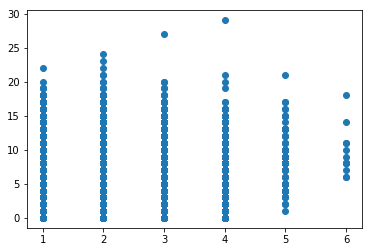

In [773]:
plt.scatter(final_frame['In_Store'], final_frame['traffic_out'])

In [771]:
traffic_frame.describe()

,store_no,traffic_in,traffic_out,day
count,148072.000000,148072.000000,148072.000000,148072.000000
mean,432.496326,3.074788,3.092570,2.859960
std,251.608867,2.570049,2.567897,1.937116
min,18.000000,0.000000,0.000000,0.000000
25%,214.000000,1.000000,1.000000,1.000000
50%,444.000000,3.000000,3.000000,3.000000
75%,612.000000,4.000000,4.000000,5.000000
max,1013.000000,29.000000,29.000000,6.000000


In [726]:
traffic_frame.dtypes

traffic_from     datetime64[ns]
traffic_until    datetime64[ns]
store_no                  int64
store_name               object
traffic_in                int64
traffic_out               int64
day                       int64
weekend                    bool
dtype: object

In [728]:
traffic_frame

,traffic_from,traffic_until,store_no,store_name,traffic_in,traffic_out,day,weekend
0,2019-01-02 08:00:00,2019-01-02 08:14:00,60,None,1,0,2,False
1,2019-01-02 08:15:00,2019-01-02 08:29:00,60,None,3,4,2,False
2,2019-01-02 08:30:00,2019-01-02 08:44:00,60,None,1,1,2,False
3,2019-01-02 08:45:00,2019-01-02 08:59:00,60,None,4,3,2,False
4,2019-01-02 09:00:00,2019-01-02 09:14:00,18,None,4,0,2,False
5,2019-01-02 09:00:00,2019-01-02 09:14:00,28,None,3,3,2,False
6,2019-01-02 09:00:00,2019-01-02 09:14:00,30,None,4,3,2,False
7,2019-01-02 09:00:00,2019-01-02 09:14:00,40,None,4,3,2,False
8,2019-01-02 09:00:00,2019-01-02 09:14:00,47,None,1,0,2,False
9,2019-01-02 09:00:00,2019-01-02 09:14:00,60,None,2,3,2,False


limit_output extension: Maximum message size of 10000 exceeded with 13973 characters

In [738]:
grouped_emp_frame

,hours,Store_Number,In_Store
0,2018-12-30 06:00:00,303,1
1,2018-12-30 06:00:00,568,1
2,2018-12-30 06:15:00,303,1
3,2018-12-30 06:15:00,568,1
4,2018-12-30 06:30:00,303,1
5,2018-12-30 06:30:00,568,1
6,2018-12-30 06:45:00,303,1
7,2018-12-30 06:45:00,568,1
8,2018-12-30 07:00:00,246,1
9,2018-12-30 07:00:00,303,1


In [63]:
traffic_frame.traffic_in.min()

0

In [86]:
#Let's validate our data by comparing it to the retailnext front end 
#Pick a random day 
tempTable = traffic_frame[traffic_frame['traffic_from'].dt.date== dt.date(2019, 1, 8)]
#look at the hourly totals 
tempTable['traffic_in'].groupby(tempTable.traffic_from.dt.hour).sum()

traffic_from
8        8
9      510
10     810
11    1009
12    1165
13    1124
14    1128
15    1056
16    1016
17     970
18     810
19     766
20     456
Name: traffic_in, dtype: int64

In [94]:
print("Traffic data from {} to {}".format(traffic_frame.traffic_from.min(),traffic_frame.traffic_from.max()))

Traffic data from 2018-12-30 10:00:00 to 2019-02-10 18:00:00


In [95]:
traffic_frame.traffic_in.describe()

count    37018.000000
mean        12.299152
std          7.375186
min          0.000000
25%          7.000000
50%         11.000000
75%         16.000000
max         63.000000
Name: traffic_in, dtype: float64

In [96]:
traffic_frame.traffic_out.describe()

count    37018.000000
mean        12.370279
std          7.380441
min          0.000000
25%          7.000000
50%         11.000000
75%         16.000000
max         64.000000
Name: traffic_out, dtype: float64

In [71]:
traffic_frame['traffic_in'].groupby(traffic_frame.traffic_from.dt.hour).sum()

traffic_from
8       268
9     17823
10    29478
11    46167
12    52157
13    53602
14    52331
15    50571
16    46796
17    41386
18    28656
19    22298
20    13757
Name: traffic_in, dtype: int64

In [142]:
graphFrame = pd.DataFrame(traffic_frame['traffic_in'].groupby((traffic_frame.traffic_from.dt.hour, traffic_frame.weekend)).mean())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [136]:
graphFrame = graphFrame.unstack()

In [146]:
graphFrame

traffic_in
traffic_from weekend            
8            False      8.933333
9            False      6.919753
             True       7.850242
10           False      9.710970
             True      13.056566
11           False     12.562447
             True      16.643655
12           False     14.382700
             True      17.594937
13           False     14.603376
             True      18.492697
14           False     14.139241
             True      18.326193
15           False     13.755696
             True      17.497566
16           False     13.000000
             True      15.565725
17           False     12.126160
             True      12.571571
18           False      9.992405
             True      10.171779
19           False      8.072222
             True       7.475877
20           False      6.264331
             True       5.617816

In [69]:
tempTable['traffic_in']

152       7
231      17
310      11
389       9
468      17
544      14
698      10
777      11
856      12
935      19
1014     17
1093     21
1172     18
1251      6
1330      3
1408      0
1470      0
1620      1
1699      4
1778      9
1857      9
1936     14
2015     12
2094      6
2173      6
2252      0
2330      0
2393      0
2543      7
2622     11
         ..
34595    13
34674    22
34753    16
34832    10
34937     8
35016    12
35095     8
35174     6
35253    23
35332    11
35400    13
35479    17
35558    14
35634    18
35655     6
35733    10
35796     6
35944     8
36023     7
36102    16
36181    18
36260    18
36339    20
36418    17
36497    12
36575    18
36651     6
36709     6
36864     6
36943    12
Name: traffic_in, Length: 438, dtype: int64

In [70]:
traffic_frame['traffic_in'].groupby(traffic_frame.traffic_from.dt.hour).mean()

traffic_from
8      8.933333
9      7.072619
10    10.289005
11    13.760656
12    15.353842
13    15.779217
14    15.405063
15    14.886959
16    13.775684
17    12.258886
18    10.023085
19     7.974964
20     6.163530
Name: traffic_in, dtype: float64

In [ ]:
traffic_frame['traffic_in'].groupby(traffic_frame.traffic_from.dt.hour).mean()

28
229
397
18
30
40
47
67
69
71
120
136
144
147
167
187
192
201
210
214
242
275
297
301
309
312
314
315
319
323
342
350
355
357
359
388
442
450
452
453
456
466
488
511
517
528
536
554
559
571
583
597
598
607
612
616
617
623
633
679
689
703
710
712
763
777
784
823
828
833
861
1003
1013
60
189
444
507
573
868


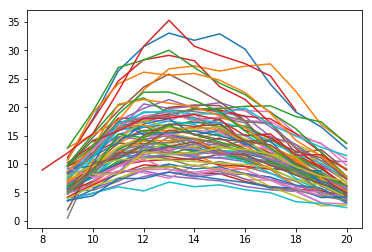

In [56]:
for i in list(traffic_frame['store_no'].unique()):
    tempTable = traffic_frame[traffic_frame['store_no']== i]
    print(i)
    plt.plot(tempTable['traffic_in'].groupby(tempTable.traffic_from.dt.hour).mean())

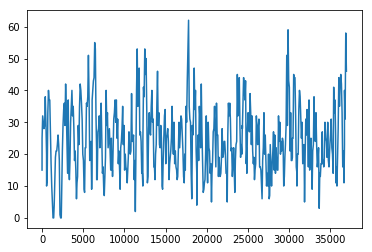

In [268]:
plt.plot(traffic_frame[traffic_frame['store_no']== 28]['traffic_in'])

In [ ]:
traffic_frame

In [ ]:
traffic_frame.traffic_from.max()

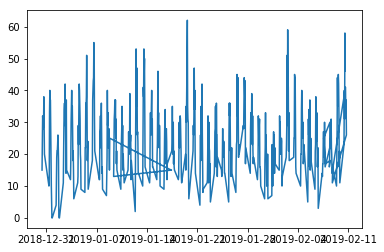

In [43]:
plt.plot('traffic_from', 'traffic_in', data=traffic_frame[traffic_frame['store_no']== 28])

In [215]:
storeSales_frame.dtypes

transaction_datetime              datetime64[ns]
store_no                                   int64
transaction_count                          int64
total_amount                             float64
AvgTransactionAmntEvryHalfHour           float64
dtype: object

In [216]:
traffic_frame.dtypes

traffic_from     datetime64[ns]
traffic_until    datetime64[ns]
store_no                  int64
store_name               object
traffic_in                int64
traffic_out               int64
day                       int64
weekend                    bool
dtype: object

In [220]:
punchTimesDF.dtypes

Store_Number               int64
EE_Number                  int64
Name                      object
Title                     object
In_Date                   object
In_Time                   object
Out_Date                  object
Out_Time                  object
in                datetime64[ns]
out               datetime64[ns]
raw_hours        timedelta64[ns]
rounded_in        datetime64[ns]
rounded_out       datetime64[ns]
rounded_hours    timedelta64[ns]
dtype: object

In [262]:
for i in list(new_df['store_no'].unique()):
    temp_df = new_df[new_df['store_no']==i]
    temp_df.dropna(inplace=True)
    print('store {} has correlation {} between traffic and sales'.format(i, np.round((np.corrcoef(temp_df['transaction_count'], temp_df['traffic_out'])[0][1]), 4)))



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


store 18 has correlation 0.919 between traffic and sales
store 28 has correlation 0.9551 between traffic and sales
store 30 has correlation 0.915 between traffic and sales
store 40 has correlation 0.9384 between traffic and sales
store 47 has correlation 0.8726 between traffic and sales
store 60 has correlation 0.9283 between traffic and sales
store 67 has correlation 0.8588 between traffic and sales
store 69 has correlation 0.8274 between traffic and sales
store 71 has correlation 0.898 between traffic and sales
store 120 has correlation 0.8945 between traffic and sales
store 136 has correlation 0.8767 between traffic and sales
store 144 has correlation 0.8987 between traffic and sales
store 147 has correlation 0.9061 between traffic and sales
store 167 has correlation 0.9329 between traffic and sales
store 187 has correlation 0.9551 between traffic and sales
store 189 has correlation 0.844 between traffic and sales
store 192 has correlation 0.8731 between traffic and sales
store 201 

In [410]:
results_frame[results_frame.index == 187]

,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,nan
187,NaN,0.9394,0.8609,0.9228,0.8785,0.9195,0.8298,0.9271,0.9321,0.8972,0.9116,0.9206,0.8456,NaN


In [412]:
temp_df = new_df[new_df['store_no']==187]
temp_df = temp_df[temp_df.weekend == False]
temp_df = temp_df[temp_df.traffic_until.dt.hour == 18]
np.corrcoef(temp_df['transaction_count'], temp_df['traffic_out'])


array([[1.        , 0.89721989],
       [0.89721989, 1.        ]])

In [393]:
temp_df.shape

(28, 12)

In [913]:
final_frame

,traffic_from,traffic_until,store_no,traffic_in,traffic_out,day,weekend,hours,Store_Number,In_Store,transaction_datetime,transaction_count,total_amount,AOV5min,conv_rate,cust_to_emp
0,2019-01-02 08:00:00,2019-01-02 08:15:00,60,1,0,2,False,2019-01-02 08:15:00,60.0,1.0,NaT,0.0,0.00,0.000000,0.000000,0.000000
1,2019-01-02 08:15:00,2019-01-02 08:30:00,60,3,4,2,False,2019-01-02 08:30:00,60.0,1.0,2019-01-02 08:30:00,4.0,43.37,10.842500,1.000000,4.000000
2,2019-01-02 08:30:00,2019-01-02 08:45:00,60,1,1,2,False,2019-01-02 08:45:00,60.0,1.0,2019-01-02 08:45:00,1.0,11.04,11.040000,1.000000,1.000000
3,2019-01-02 08:45:00,2019-01-02 09:00:00,60,4,3,2,False,2019-01-02 09:00:00,60.0,1.0,2019-01-02 09:00:00,2.0,71.98,35.990000,0.666667,3.000000
4,2019-01-02 09:00:00,2019-01-02 09:15:00,18,4,0,2,False,NaT,NaN,1.0,NaT,0.0,0.00,0.000000,0.000000,NaN
5,2019-01-02 09:00:00,2019-01-02 09:15:00,28,3,3,2,False,2019-01-02 09:15:00,28.0,3.0,2019-01-02 09:15:00,1.0,41.39,41.390000,0.333333,1.000000
6,2019-01-02 09:00:00,2019-01-02 09:15:00,30,4,3,2,False,2019-01-02 09:15:00,30.0,1.0,2019-01-02 09:15:00,2.0,147.18,73.590000,0.666667,3.000000
7,2019-01-02 09:00:00,2019-01-02 09:15:00,40,4,3,2,False,2019-01-02 09:15:00,40.0,1.0,2019-01-02 09:15:00,3.0,99.61,33.203333,1.000000,3.000000
8,2019-01-02 09:00:00,2019-01-02 09:15:00,47,1,0,2,False,2019-01-02 09:15:00,47.0,1.0,NaT,0.0,0.00,0.000000,0.000000,0.000000
9,2019-01-02 09:00:00,2019-01-02 09:15:00,60,2,3,2,False,2019-01-02 09:15:00,60.0,1.0,2019-01-02 09:15:00,2.0,131.42,65.710000,0.666667,3.000000


limit_output extension: Maximum message size of 10000 exceeded with 25810 characters

In [912]:
final_frame.cust_to_emp

0          0.000000
1          4.000000
2          1.000000
3          3.000000
4               NaN
5          1.000000
6          3.000000
7          3.000000
8          0.000000
9          3.000000
10              NaN
11         2.000000
12         2.000000
13         0.000000
14         2.000000
15              NaN
16         2.000000
17         0.000000
18         3.000000
19              NaN
20              NaN
21         0.000000
22         2.000000
23         1.000000
24         0.000000
25         1.000000
26              NaN
27         2.000000
28         3.000000
29         0.000000
            ...    
148042     1.000000
148043     0.000000
148044     3.500000
148045    12.000000
148046     1.500000
148047     8.000000
148048     1.000000
148049     5.000000
148050     2.000000
148051     1.000000
148052     1.000000
148053          NaN
148054     3.000000
148055          NaN
148056          NaN
148057     1.500000
148058     0.000000
148059     1.000000
148060     3.000000


In [399]:
temp_df2

,transaction_datetime,store_no,transaction_count,total_amount,AvgTransactionAmntEvryHalfHour,traffic_from,traffic_until,store_name,traffic_in,traffic_out,day,weekend
7364,2019-02-07 20:00:00,187,4,97.11,24.2775,2019-02-07 20:00:00,2019-02-07 21:00:00,"Franklin, TN",5.0,6.0,3.0,False
7377,2019-02-08 20:00:00,187,8,241.36,30.1700,2019-02-08 20:00:00,2019-02-08 21:00:00,"Franklin, TN",9.0,9.0,4.0,False


In [385]:
temp_df

,transaction_datetime,store_no,transaction_count,total_amount,AvgTransactionAmntEvryHalfHour,traffic_from,traffic_until,store_name,traffic_in,traffic_out,day,weekend
6947,2019-01-02 20:00:00,187,6,476.52,79.420000,2019-01-02 20:00:00,2019-01-02 21:00:00,None,8.0,10.0,2.0,False
6960,2019-01-03 20:00:00,187,3,103.37,34.456666,2019-01-03 20:00:00,2019-01-03 21:00:00,None,4.0,5.0,3.0,False
6972,2019-01-04 20:00:00,187,2,232.92,116.460000,2019-01-04 20:00:00,2019-01-04 21:00:00,None,3.0,3.0,4.0,False
7004,2019-01-07 20:00:00,187,8,289.48,36.185000,2019-01-07 20:00:00,2019-01-07 21:00:00,None,6.0,6.0,0.0,False
7016,2019-01-08 20:00:00,187,3,76.74,25.580000,2019-01-08 20:00:00,2019-01-08 21:00:00,None,4.0,5.0,1.0,False
7030,2019-01-09 20:00:00,187,6,187.58,31.263333,2019-01-09 20:00:00,2019-01-09 21:00:00,None,7.0,8.0,2.0,False
7042,2019-01-10 20:00:00,187,3,66.15,22.050000,2019-01-10 20:00:00,2019-01-10 21:00:00,None,6.0,6.0,3.0,False
7054,2019-01-11 20:00:00,187,5,153.08,30.616000,2019-01-11 20:00:00,2019-01-11 21:00:00,None,5.0,8.0,4.0,False
7085,2019-01-14 20:00:00,187,8,375.69,46.961250,2019-01-14 20:00:00,2019-01-14 21:00:00,None,7.0,10.0,0.0,False
7097,2019-01-15 20:00:00,187,6,278.96,46.493333,2019-01-15 20:00:00,2019-01-15 21:00:00,None,6.0,8.0,1.0,False


In [407]:
del new_df['store_name']

In [322]:
new_df[new_df.transaction_datetime.dt.hour==1]

,transaction_datetime,store_no,transaction_count,total_amount,AvgTransactionAmntEvryHalfHour,traffic_from,traffic_until,store_name,traffic_in,traffic_out,day,weekend
5953,2019-01-05 01:00:00,147,1,35.0,35.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [904]:
results_frame = pd.DataFrame(columns=np.sort(final_frame.traffic_until.dt.hour.unique()), index=final_frame.store_no.unique())

for i in list(final_frame['store_no'].unique()):
#for i in list([187]):
    temp_df = final_frame[final_frame['store_no']==i]
    temp_df = temp_df[temp_df.weekend == False]
    print(temp_df.shape)
    for j in list(temp_df.traffic_until.dt.hour.unique()):
        temp_df2 = temp_df[temp_df.traffic_until.dt.hour == j]
        
        temp_df2.dropna(inplace=True)
        print(temp_df2.shape)
        results_frame.loc[i,j]= np.round((np.corrcoef(temp_df2['transaction_count'], temp_df2['In_Store'])[0][1]), 4)
    
        print('store {} in hour {} has correlation {} between traffic and sales'.format(i, j, np.round((np.corrcoef(temp_df2['transaction_count'], temp_df2['traffic_out'])[0][1]), 4)))
        #del temp_df2


(1320, 16)
(57, 16)
store 60 in hour 8 has correlation 0.7694 between traffic and sales
(97, 16)
store 60 in hour 9 has correlation 0.6866 between traffic and sales
(109, 16)
store 60 in hour 10 has correlation 0.7161 between traffic and sales
(111, 16)
store 60 in hour 11 has correlation 0.8169 between traffic and sales
(118, 16)
store 60 in hour 12 has correlation 0.828 between traffic and sales


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


(120, 16)
store 60 in hour 13 has correlation 0.7994 between traffic and sales
(118, 16)
store 60 in hour 14 has correlation 0.7468 between traffic and sales
(120, 16)
store 60 in hour 15 has correlation 0.727 between traffic and sales
(118, 16)
store 60 in hour 16 has correlation 0.7871 between traffic and sales
(117, 16)
store 60 in hour 17 has correlation 0.8419 between traffic and sales
(117, 16)
store 60 in hour 18 has correlation 0.7324 between traffic and sales
(26, 16)
store 60 in hour 19 has correlation 0.7693 between traffic and sales
(1440, 16)
(34, 16)
store 18 in hour 9 has correlation 0.6538 between traffic and sales
(85, 16)
store 18 in hour 10 has correlation 0.7374 between traffic and sales
(83, 16)
store 18 in hour 11 has correlation 0.6129 between traffic and sales
(107, 16)
store 18 in hour 12 has correlation 0.6664 between traffic and sales
(112, 16)
store 18 in hour 13 has correlation 0.7686 between traffic and sales
(115, 16)
store 18 in hour 14 has correlation 0

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


store 67 in hour 12 has correlation 0.833 between traffic and sales
(115, 16)
store 67 in hour 13 has correlation 0.8618 between traffic and sales
(118, 16)
store 67 in hour 14 has correlation 0.7196 between traffic and sales
(111, 16)
store 67 in hour 15 has correlation 0.8367 between traffic and sales
(114, 16)
store 67 in hour 16 has correlation 0.7727 between traffic and sales
(111, 16)
store 67 in hour 17 has correlation 0.7758 between traffic and sales
(97, 16)
store 67 in hour 18 has correlation 0.7829 between traffic and sales
(87, 16)
store 67 in hour 19 has correlation 0.7702 between traffic and sales
(82, 16)
store 67 in hour 20 has correlation 0.8261 between traffic and sales
(14, 16)
store 67 in hour 21 has correlation 0.82 between traffic and sales
(1440, 16)
(36, 16)
store 69 in hour 9 has correlation 0.7604 between traffic and sales
(57, 16)
store 69 in hour 10 has correlation 0.609 between traffic and sales
(62, 16)
store 69 in hour 11 has correlation 0.8177 between tr

limit_output extension: Maximum message size of 10000 exceeded with 10083 characters

In [360]:
results_frame[results_frame.index == 187]

,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,nan
187,NaN,0.7777,0.9182,0.9574,0.8433,0.9891,0.8325,0.914,0.9647,0.3015,0.9967,1,1,NaN


In [902]:
results_frame

,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,nan
18,NaN,0.8381,0.7266,0.7454,0.6954,0.8342,0.8461,0.8484,0.8445,0.7946,0.7972,0.9113,0.8326,NaN
28,NaN,0.8602,0.7707,0.7368,0.8916,0.8771,0.8863,0.8107,0.8704,0.8857,0.8404,0.8647,0.8107,NaN
30,NaN,0.8348,0.9075,0.8062,0.836,0.8841,0.8729,0.7693,0.9133,0.8446,0.8923,0.7553,0.739,NaN
40,NaN,0.8411,0.7074,0.9294,0.9283,0.8269,0.8989,0.8087,0.8298,0.7994,0.8934,0.8895,0.81,NaN
47,NaN,0.7581,0.5802,0.7433,0.5256,0.7631,0.7198,0.7656,0.6474,0.5496,0.8414,0.8252,0.5963,NaN
60,0.8617,0.8745,0.8604,0.8732,0.9153,0.898,0.8394,0.8893,0.8954,0.8923,0.8035,NaN,NaN,NaN
67,NaN,0.807,0.8132,0.8554,0.9368,0.9425,0.8512,0.8629,0.7703,0.7946,0.7729,0.9245,0.8625,NaN
69,NaN,0.7474,0.8869,0.7747,0.8406,0.7258,0.7541,0.8927,0.8232,0.9129,0.7991,0.8998,0.8924,NaN
71,NaN,0.4485,0.417,0.751,0.8298,0.7398,0.8692,0.544,0.8124,0.8499,0.8015,0.9011,0.8076,NaN
120,NaN,0.8252,0.803,0.8769,0.9199,0.8229,0.8716,0.8552,0.8797,0.8813,0.9269,0.8374,0.7904,NaN


limit_output extension: Maximum message size of 10000 exceeded with 21266 characters

In [908]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of


In [905]:
results_frame.to_clipboard()

In [ ]:
np.corrcoef(new_df['transaction_count'], new_df['total_amount'])